# Орлогын таамаглал (Логистик регресс)
Хялбаршуулсан дэвтэр: загвар ачаалах, таамаглах, үнэлэх.

## Өгөгдөл

**Эх сурвалж:** Adult Income Dataset (Census Bureau)
https://www.kaggle.com/datasets/mastmustu/income

**Проблем:** Predict whether a person earns >$50K/year based on demographic and work-related features

**Dataset statistics:**
- **Нийт дээж:** 43957 (original 32,561-с сургалт/баталгаажуулалтын хуваарилалтаар)
- **Сургалтын багц:** 35165 дээж (80%)
- **Баталгаажуулалтын багц:** 8792 дээж (20%)

**Ангиудын тархалт:**
- **≤$50K:** ~76% (ихэнх анги - тэнцвэргүй)
- **>$50K:** ~24% (цөөн анги)

**Онцлог шинж чанарууд ( нийт 13 ):**
- **Тоон (5):** нас, боловсролын дугаар, капиталын ашиг, капиталын алдагдал, цагийн ажиллах
- **Категори (8):** ажиллах анги, боловсрол, гэрлэлтийн байдал, мэргэжил, харилцаа, арьс өнгө, хүйс, эх орон

**Зорилтот хувьсагч:** `income_>50K` (хоёртын: 0 = ≤50K, 1 = >50K)

**Сорилт:** Ангийн тэнцвэргүй байдал энэ асуудлыг илүү хэцүү болгодог - загвар 75% үнэнч байдлыг зөвхөн ≤50K-ийг үргэлж таамаглах замаар олж авах боломжтой!

In [21]:
import sys
sys.path.append('../src')

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

from utils import load_model

## Өгөгдөл болон загварыг ачаалах

Дахин давтагдах боломжийг хангахын тулд урьдчилан хуваарилсан өгөгдлийг ашиглана.

In [22]:
val_df = pd.read_csv('../data/val_split.csv')
X_val = val_df.drop(columns=['income_>50K'])
y_val = val_df['income_>50K']

model = load_model()
preprocessor = model.named_steps['preprocess']
logreg = model.named_steps['logreg']

X_val_processed = preprocessor.transform(X_val)
y_pred = logreg.predict(X_val_processed)

## Логистик регресс

Бидний хэрэгжилт нь градиент бууруулалт ашигладаг. Дараах график нь хCross-Entropy алдаа ба гиперпараметр сургалтын хурдны давтамжийн тоог харуулж байна

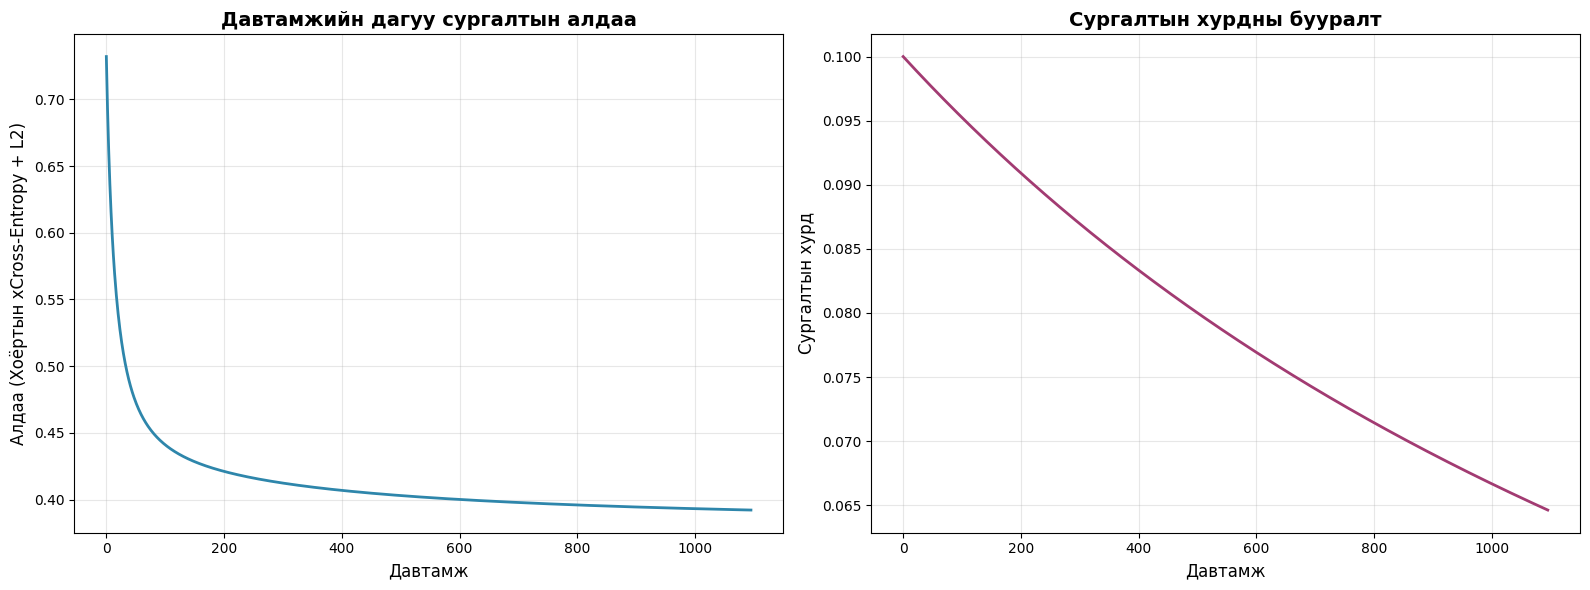

Эхний алдаа: 0.7320
Сүүлийн алдаа: 0.3922
Нийт давтамж: 1096
Алдааны бууралт: 46.43%


In [23]:
# Алдааны сургалтын муруйг зур
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Алдааны муруй
ax1.plot(logreg.losses, linewidth=2, color='#2E86AB')
ax1.set_xlabel('Давтамж', fontsize=12)
ax1.set_ylabel('Алдаа (Хоёртын хCross-Entropy + L2)', fontsize=12)
ax1.set_title('Давтамжийн дагуу сургалтын алдаа', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Сургалтын хурдны бууралт (хэрэв боломжтой бол)
if hasattr(logreg, 'initial_lr') and hasattr(logreg, 'lr_decay'):
    iterations = range(len(logreg.losses))
    learning_rates = [logreg.initial_lr / (1 + logreg.lr_decay * i) for i in iterations]
    ax2.plot(learning_rates, linewidth=2, color='#A23B72')
    ax2.set_xlabel('Давтамж', fontsize=12)
    ax2.set_ylabel('Сургалтын хурд', fontsize=12)
    ax2.set_title('Сургалтын хурдны бууралт', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)
else:
    # Загварыг хуучин хувилбараар сургаж байсан - мэдээллийн мессежийг харуул
    ax2.text(0.5, 0.5, 'Сургалтын хурдны бууралт боломжгүй байна\n(энэ графикийг харахын тулд загварыг дахин сургаарай)', 
             ha='center', va='center', fontsize=12, transform=ax2.transAxes)
    ax2.set_title('Сургалтын хурдны бууралт', fontsize=14, fontweight='bold')
    ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"Эхний алдаа: {logreg.losses[0]:.4f}")
print(f"Сүүлийн алдаа: {logreg.losses[-1]:.4f}")
print(f"Нийт давтамж: {len(logreg.losses)}")
print(f"Алдааны бууралт: {((logreg.losses[0] - logreg.losses[-1]) / logreg.losses[0] * 100):.2f}%")

# Хэрэв загварыг дахин сургах шаардлагатай бол шалгах
if not hasattr(logreg, 'initial_lr'):
    print("\n⚠️  Загварыг хуучин хувилбараар сургаж байсан. Шинэчлэлтүүдийг харахын тулд дахин сургаарай:")
    print("   cd ../src && python train_model.py")

## 3. Загварын гүйцэтгэлийн үзүүлэлтүүд

In [24]:
# Үзүүлэлтүүдийг тооцоол
metrics = {
    'Нарийвчлал (Accuracy)':  accuracy_score(y_val, y_pred),
    'Тодорхойлолт (Precision)': precision_score(y_val, y_pred),
    'Мэдрэмж (Recall)':    recall_score(y_val, y_pred),
    'F1 оноо':        f1_score(y_val, y_pred)
}

# Үзүүлэлтүүдийн дата хүрээг бий болгох
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Үзүүлэлт','Оноо'])
metrics_df

,Үзүүлэлт,Оноо
0,Нарийвчлал (Accuracy),0.797202
1,Тодорхойлолт (Precision),0.549706
2,Мэдрэмж (Recall),0.843631
3,F1 оноо,0.665667


## 4. Будлианы матриц

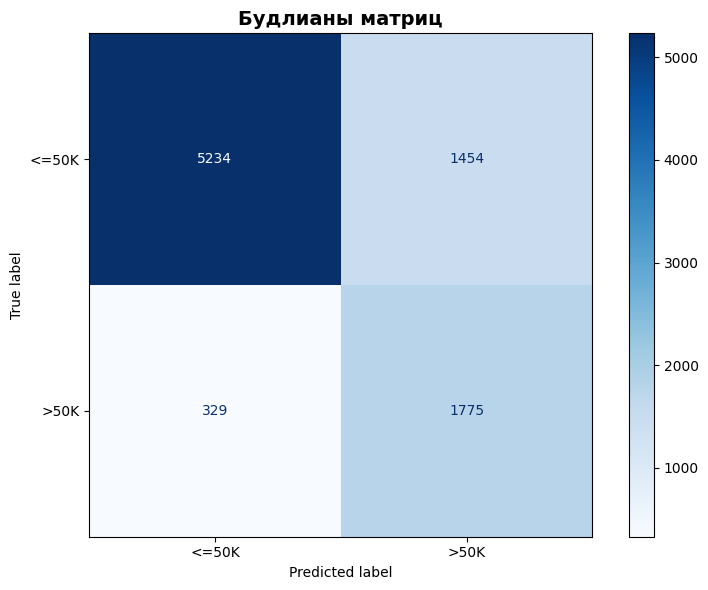


Үнэн сөрөг:   5234
Хуурамч эерэг:  1454
Хуурамч сөрөг:   329
Үнэн эерэг:   1775


In [25]:
cm = confusion_matrix(y_val, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K','>50K'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Будлианы матриц', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nҮнэн сөрөг:  {cm[0][0]:5d}")
print(f"Хуурамч эерэг: {cm[0][1]:5d}")
print(f"Хуурамч сөрөг: {cm[1][0]:5d}")
print(f"Үнэн эерэг:  {cm[1][1]:5d}")

## 5. Ангиллын тайлан

In [26]:
print(classification_report(y_val, y_pred, target_names=['<=50K','>50K']))

              precision    recall  f1-score   support

       <=50K       0.94      0.78      0.85      6688
        >50K       0.55      0.84      0.67      2104

    accuracy                           0.80      8792
   macro avg       0.75      0.81      0.76      8792
weighted avg       0.85      0.80      0.81      8792



## 6. Үзүүлэлтүүд

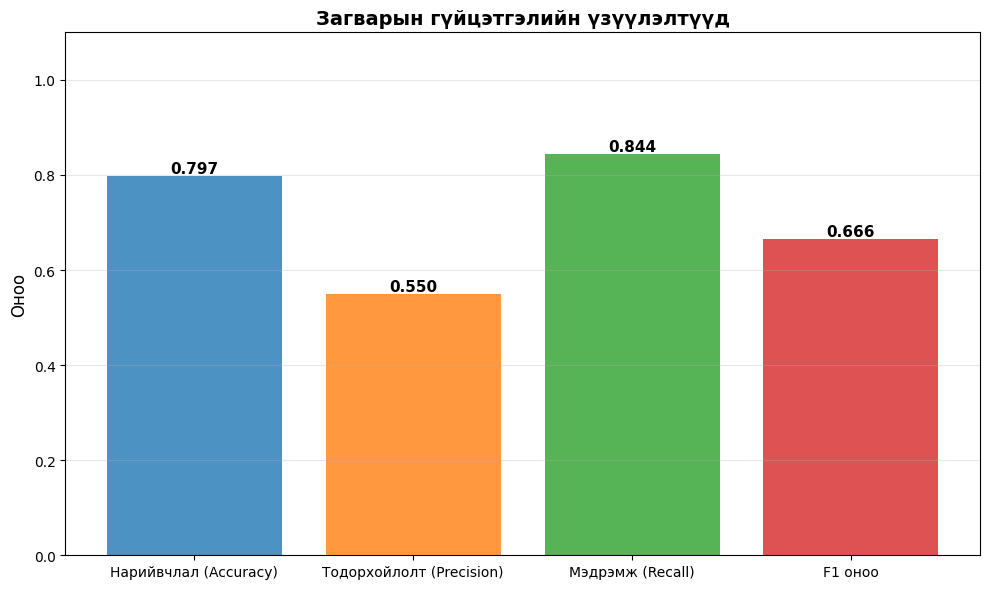

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

metric_names = list(metrics.keys())
metric_values = list(metrics.values())

bars = ax.bar(metric_names, metric_values, 
              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], 
              alpha=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.3f}',
           ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Оноо', fontsize=12)
ax.set_title('Загварын гүйцэтгэлийн үзүүлэлтүүд', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Онцлогийн жин
- **Ногоон баар:** Орлогын >50K магадлалыг нэмэгдүүлдэг онцлогууд
- **Улаан баар:** Орлогын >50K магадлалыг бууруулдаг онцлогууд
- Жингийн хэмжээ нь онцлогийн чухал байдлыг илэрхийлнэ

In [ ]:
# Build importance_df from model coefficients and feature names, then plot top features
top_n = 15

# Extract feature names from the preprocessor
# numeric feature names
num_features = preprocessor.transformers_[0][2]
# categorical feature names (one-hot encoded)
cat_cols = preprocessor.transformers_[1][2]
encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_feature_names = encoder.get_feature_names_out(cat_cols)

feature_names = list(num_features) + list(cat_feature_names)

# Try to find coefficients on the custom logreg object (support several common attribute names)
coef_attr_candidates = ['coef_', 'w', 'weights', 'theta']
coefs = None
for attr in coef_attr_candidates:
	if hasattr(logreg, attr):
		coefs = getattr(logreg, attr)
		break

if coefs is None:
	raise AttributeError(
		"Could not find coefficient attribute on logreg. "
		"Look for attributes like 'coef_', 'w', 'weights' or 'theta' on your logistic regression implementation."
	)

coefs = np.array(coefs).ravel()

# Align coefficient vector with feature names if an intercept is included
if coefs.shape[0] == len(feature_names) + 1:
	# assume intercept present as first element
	coefs = coefs[1:]
elif coefs.shape[0] - 1 == len(feature_names):
	# intercept at end
	coefs = coefs[:-1]
elif coefs.shape[0] != len(feature_names):
	raise ValueError(f"Coefficient length ({coefs.shape[0]}) does not match number of features ({len(feature_names)}).")

importance_df = pd.DataFrame({'Feature': feature_names, 'Weight': coefs})
importance_df = importance_df.reindex(importance_df.Weight.abs().sort_values(ascending=False).index).reset_index(drop=True)

# Plot top N features
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['green' if x > 0 else 'red' for x in top_features['Weight']]

ax.barh(range(len(top_features)), top_features['Weight'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Weight value', fontsize=12)
ax.set_title(f'Top {top_n} Feature weights', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
display(top_features)

AttributeError: 'DataFrame' object has no attribute 'Weight'

## 8. Сигмоид функц

Сигмоид функц σ(z) = 1/(1 + e^(-z)) шугаман таамаглалуудаас магадлал руу хөрвүүлдэг.
Математикийн функц болон манай загварын таамаглалууд хэрхэн тархсан байдлыг визуализацийн хамт үзүүлье.

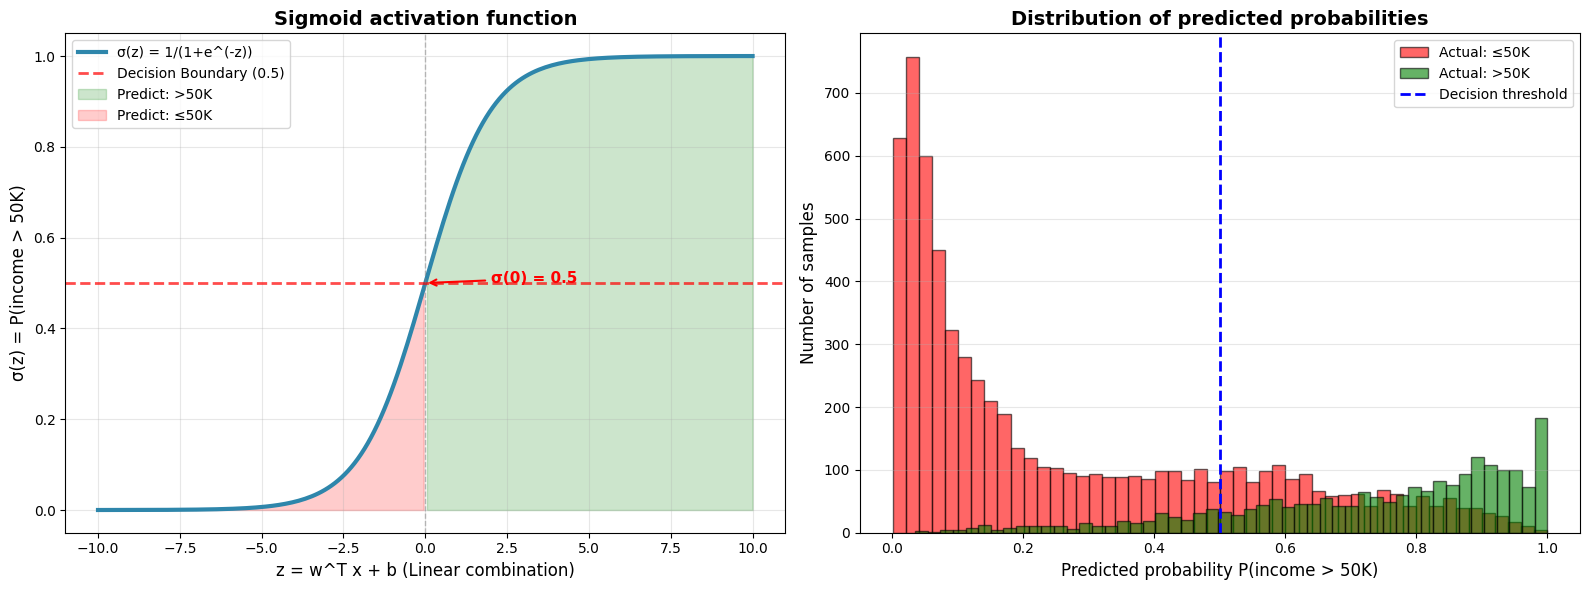


For actual ≤50K samples:
  Mean probability: 0.2629
  Median probability: 0.1469
  Std deviation: 0.2595

For actual >50K samples:
  Mean probability: 0.7358
  Median probability: 0.7958
  Std deviation: 0.2166


In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

z_range = np.linspace(-10, 10, 200)
sigmoid_values = logreg.sigmoid(z_range)

ax1.plot(z_range, sigmoid_values, linewidth=3, color='#2E86AB', label='σ(z) = 1/(1+e^(-z))')
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Шийдвэрийн хязгаар (0.5)')
ax1.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.fill_between(z_range, 0, sigmoid_values, where=(sigmoid_values >= 0.5), 
                  alpha=0.2, color='green', label='Таамаглах: >50K')
ax1.fill_between(z_range, 0, sigmoid_values, where=(sigmoid_values < 0.5), 
                  alpha=0.2, color='red', label='Таамаглах: ≤50K')

ax1.set_xlabel('z = w^T x + b (Шугаман нийлбэр)', fontsize=12)
ax1.set_ylabel('σ(z) = P(орлого > 50K)', fontsize=12)
ax1.set_title('Сигмоид идэвхжүүлэлтийн функц', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)
ax1.set_ylim([-0.05, 1.05])

ax1.annotate('σ(0) = 0.5', xy=(0, 0.5), xytext=(2, 0.5),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
            fontsize=11, color='red', fontweight='bold')

y_proba = logreg.predict_proba(X_val_processed)[:, 1]

proba_class0 = y_proba[y_val == 0]
proba_class1 = y_proba[y_val == 1]

ax2.hist(proba_class0, bins=50, alpha=0.6, color='red', label='Үнэн: ≤50K', edgecolor='black')
ax2.hist(proba_class1, bins=50, alpha=0.6, color='green', label='Үнэн: >50K', edgecolor='black')
ax2.axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Шийдвэрийн хязгаар')

ax2.set_xlabel('Таамагласан магадлал P(орлого > 50K)', fontsize=12)
ax2.set_ylabel('Дээжийн тоо', fontsize=12)
ax2.set_title('Таамагласан магадлалын тархалт', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nҮнэн ≤50K дээжүүдийн хувьд:")
print(f"  Дундаж магадлал: {proba_class0.mean():.4f}")
print(f"  Дундаж бус магадлал: {np.median(proba_class0):.4f}")
print(f"  Стандарт отклонение: {proba_class0.std():.4f}")

print(f"\nҮнэн >50K дээжүүдийн хувьд:")
print(f"  Дундаж магадлал: {proba_class1.mean():.4f}")
print(f"  Дундаж бус магадлал: {np.median(proba_class1):.4f}")
print(f"  Стандарт отклонение: {proba_class1.std():.4f}")

## 10. Хязгаарын оптимизаци

0.5-ийн үндсэн хязгаар нь тэнцвэргүй өгөгдлийн багцад хамгийн сайн биш байж магадгүй.
F1 оноог хамгийн их байлгахын тулд хамгийн сайн хязгаарыг олоорой.

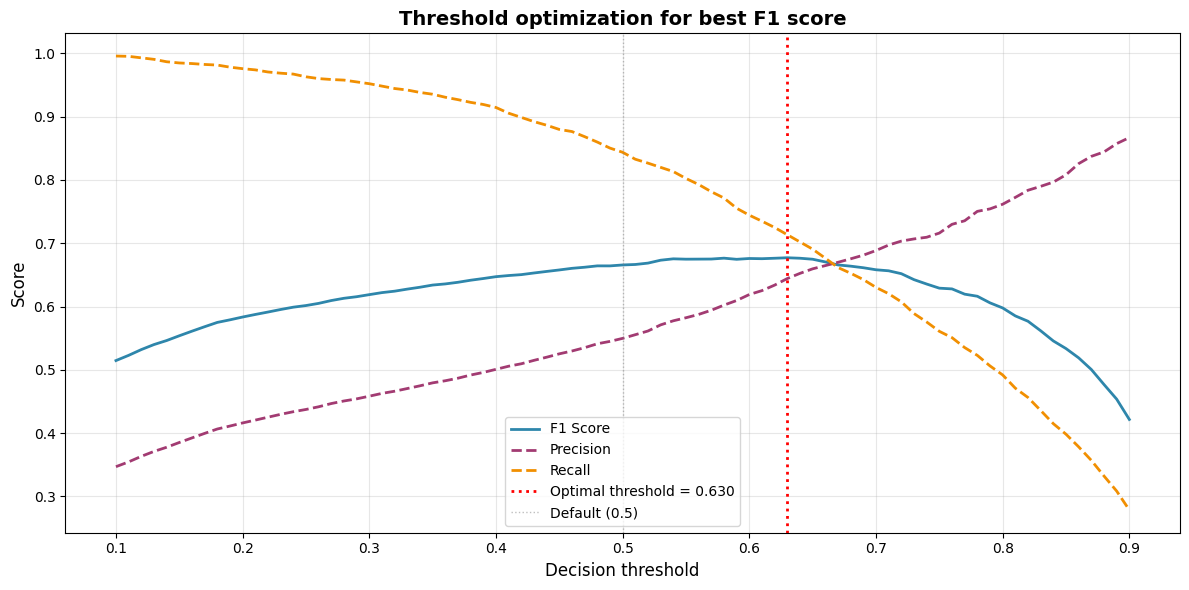


Optimal threshold: 0.630
Max F1 score: 0.6770
  Precision: 0.6442
  Recall:    0.7134


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Өөр өөр хязгаарыг туршиж үзэх
thresholds = np.linspace(0.1, 0.9, 81)
y_proba = logreg.predict_proba(X_val_processed)[:, 1]

f1_scores = []
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_thresh))
    precision_scores.append(precision_score(y_val, y_pred_thresh))
    recall_scores.append(recall_score(y_val, y_pred_thresh))

# Шийдвэрлэх хамгийн сайн хязгаарыг олох
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Зурах
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(thresholds, f1_scores, linewidth=2, label='F1 оноо', color='#2E86AB')
ax.plot(thresholds, precision_scores, linewidth=2, label='Тодорхойлолт', color='#A23B72', linestyle='--')
ax.plot(thresholds, recall_scores, linewidth=2, label='Мэдрэмж', color='#F18F01', linestyle='--')

ax.axvline(x=optimal_threshold, color='red', linestyle=':', linewidth=2, 
           label=f'Хамгийн сайн хязгаар = {optimal_threshold:.3f}')
ax.axvline(x=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='Үндсэн (0.5)')

ax.set_xlabel('Шийдвэрийн хязгаар', fontsize=12)
ax.set_ylabel('Үзүүлэлт', fontsize=12)
ax.set_title('F1 онооны хамгийн сайн оптимизаци', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nХамгийн сайн хязгаар: {optimal_threshold:.3f}")
print(f"Хамгийн их F1 оноо: {f1_scores[optimal_idx]:.4f}")
print(f"  Тодорхойлолт: {precision_scores[optimal_idx]:.4f}")
print(f"  Мэдрэмж:    {recall_scores[optimal_idx]:.4f}")

## 11. Яагаад бид төгс үзүүлэлтүүдийг авч чадахгүй вэ

Тодорхой нэгэн зүйлсийн хоорондох **нарийвчлал-мэдрэмжийн худалдаа**:
- **Өндөр нарийвчлал** = Бага хуурамч эерэг → Бид болгоомжтой байна → Зарим үнэн эерэгийг алдаж байна (доод мэдрэмж)
- **Өндөр мэдрэмж** = Бүх үнэн эерэгийг барьж авах → Бид идэвхтэй байна → Олон хуурамч эерэг авна (доод нарийвчлал)

**Та 100% -ийг хоёуланг нь авах боломжгүй** хэрэв таны ангиуд төгс тусгаарлагдсан бол (жирийн бодит өгөгдөл хэзээ ч биш).

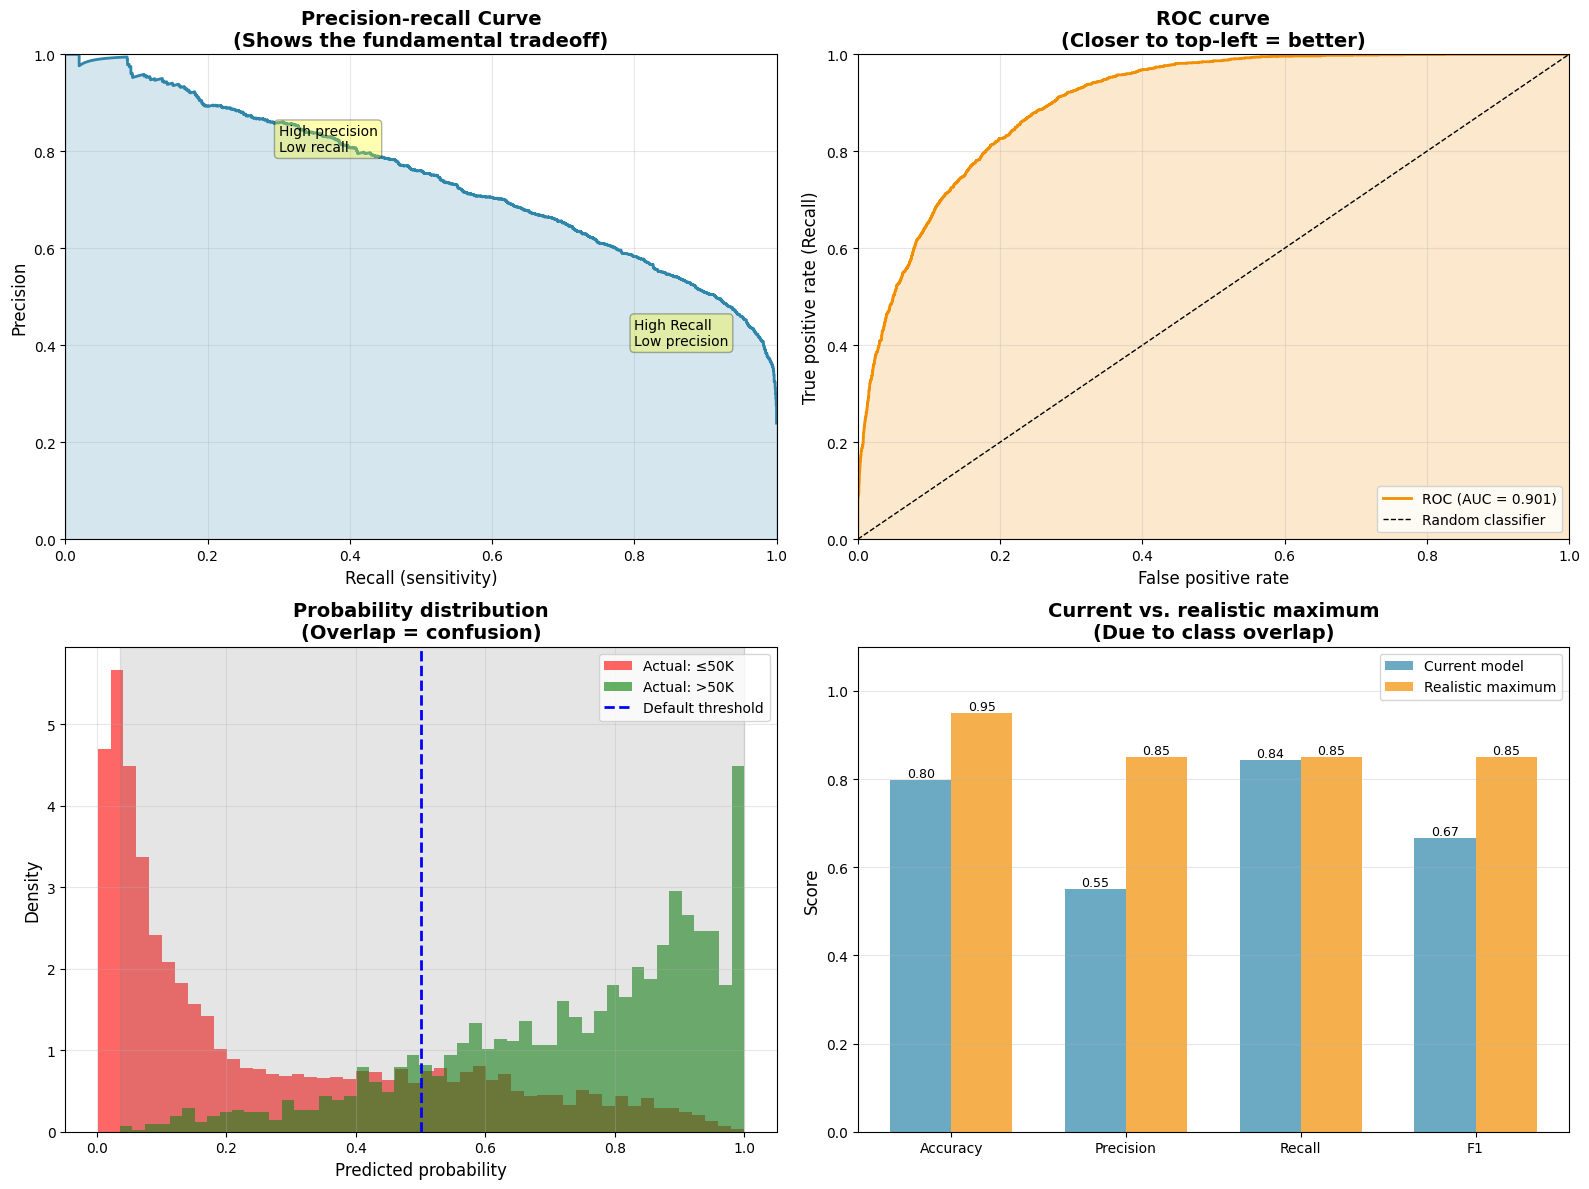

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

y_proba = logreg.predict_proba(X_val_processed)[:, 1]

precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_val, y_proba)

fpr, tpr, roc_thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

ax1.plot(recall_curve, precision_curve, linewidth=2, color='#2E86AB')
ax1.fill_between(recall_curve, precision_curve, alpha=0.2, color='#2E86AB')
ax1.set_xlabel('Мэдрэмж (сэтгэл ханамж)', fontsize=12)
ax1.set_ylabel('Нарийвчлал', fontsize=12)
ax1.set_title('Нарийвчлал-мэдрэмжийн муруй\n(Үндсэн худалдааны харуулдаг)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

ax1.annotate('Өндөр нарийвчлал\nБага мэдрэмж', xy=(0.3, 0.8), fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
ax1.annotate('Өндөр мэдрэмж\nБага нарийвчлал', xy=(0.8, 0.4), fontsize=10,
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

ax2.plot(fpr, tpr, linewidth=2, color='#F18F01', label=f'ROC (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Санамсаргүй ангилагч')
ax2.fill_between(fpr, tpr, alpha=0.2, color='#F18F01')
ax2.set_xlabel('Хуурамч эерэгийн хувь', fontsize=12)
ax2.set_ylabel('Үнэн эерэгийн хувь (Мэдрэмж)', fontsize=12)
ax2.set_title('ROC муруй\n(Дээд зүүн буланд ойртох = илүү сайн)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

proba_class0 = y_proba[y_val == 0]
proba_class1 = y_proba[y_val == 1]

ax3.hist(proba_class0, bins=50, alpha=0.6, color='red', label='Үнэн: ≤50K', density=True)
ax3.hist(proba_class1, bins=50, alpha=0.6, color='green', label='Үнэн: >50K', density=True)
ax3.axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Үндсэн хязгаар')
ax3.set_xlabel('Таамагласан магадлал', fontsize=12)
ax3.set_ylabel('Нягтрал', fontsize=12)
ax3.set_title('Магадлалын тархалт\n(Давхцал = будалт)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

overlap_min = max(proba_class0.min(), proba_class1.min())
overlap_max = min(proba_class0.max(), proba_class1.max())
ax3.axvspan(overlap_min, overlap_max, alpha=0.2, color='gray', label='Давхцал бүс')

metrics_analysis = pd.DataFrame({
    'Үзүүлэлт': ['Нарийвчлал', 'Тодорхойлолт', 'Мэдрэмж', 'F1'],
    'Одоогийн': [
        accuracy_score(y_val, y_pred),
        precision_score(y_val, y_pred),
        recall_score(y_val, y_pred),
        f1_score(y_val, y_pred)
    ],
    'Онолын Макс': [0.95, 0.85, 0.85, 0.85]  # Жинхэнэ таамаглал
})

x = np.arange(len(metrics_analysis))
width = 0.35

bars1 = ax4.bar(x - width/2, metrics_analysis['Одоогийн'], width, 
                label='Одоогийн загвар', color='#2E86AB', alpha=0.7)
bars2 = ax4.bar(x + width/2, metrics_analysis['Онолын Макс'], width,
                label='Жинхэнэ дээд хэмжээ', color='#F18F01', alpha=0.7)

ax4.set_ylabel('Оноо', fontsize=12)
ax4.set_title('Одоогийн ба жинхэнэ дээд хэмжээ\n(Ангиудын давхцалын улмаас)', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics_analysis['Үзүүлэлт'])
ax4.legend(fontsize=10)
ax4.set_ylim([0, 1.1])
ax4.grid(alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

overlap_percentage = len(y_proba[(y_proba >= overlap_min) & (y_proba <= overlap_max)]) / len(y_proba) * 100

Дээрх эсийн агуулга нь хоёртын ангилалд үндсэн худалдааны харуулж байна.

PRC нь та нарийвчлал, мэдрэмж хоёрыг зэрэгцүүлэн дээд зэргээр нэмэгдүүлэх боломжгүйг харуулж байна, ROC муруй нь нийтлэг ялгах чадварыг хэмждэг (илүү өндөр = илүү сайн)
Магадлалын давхцал нь зарим дээжийг зөв ангилах боломжгүй байдлыг харуулж байна. Одоогийн ба онолын дээд хэмжээ нь бодит гүйцэтгэлийн хүлээлтүүдийг харуулж байна.